# Argument Seperation Capability

## Import packages

In [40]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from itertools import product
from time import time
from tqdm.notebook import tqdm
from sklearn.metrics import adjusted_rand_score, completeness_score
import torch
from sentence_transformers import SentenceTransformer
from argsum import load_test_df, get_match_score_matrix, get_iterative_clusters, get_summetix_clusters, get_uskpm_clusters, get_match_clusters

##########################
### Set plt parameters ###
##########################
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.rm"] = "Times New Roman"
plt.rcParams["mathtext.it"] = "Times New Roman:italic"
plt.rcParams["mathtext.bf"] = "Times New Roman:bold"

## Define functions

In [4]:
def plot_gold_cluster_sizes(df, bin_width = 2):

    if 'key_point' in df.columns:
        arg_sum_col = 'key_point'
    elif 'summary' in df.columns:
        arg_sum_col = 'summary'

    argsums = df[arg_sum_col].unique()

    clu_sizes = []
    for argsum in argsums:
        clu_sizes.append(len(df[df[arg_sum_col] == argsum]['argument']))
    
    bins = [i for i in range(0, np.max(clu_sizes)+1, bin_width)]
    
    plt.figure(figsize=(10,4))

    plt.hist(clu_sizes, bins = bins, edgecolor = 'black', linewidth = 0.5)

    plt.xticks(ticks = [bin for bin in bins if bin % 2 == 0], labels = [bin for bin in bins if bin % 2 == 0], rotation = 90)
    
    plt.show()

def get_clusters(df, get_clusters_callable, parameter_dict, match_scorer = None, output_dir = None, file_name = None, iterative_clustering = False):
    
    # Get unique topics and stances
    topics = df['topic'].unique().tolist()
    stances = [str(int(sta)) for sta in sorted(df['stance'].unique())]

    # Get parameter for iteration
    iterate_parameter_names = [item[0] for item in parameter_dict.items() if type(item[1]) == list]
    iterate_parameter_values = [parameter_dict[parameter_name] for parameter_name in iterate_parameter_names]
    iter_parameter_value_combinations = list(product(*iterate_parameter_values))

    # Create empty dict to store the clusters
    results = dict(zip(['clustering', 'iterative_clustering', 'parameter_names', 'parameter_values'], [dict(zip([str(comb) for comb in iter_parameter_value_combinations], [dict(zip(topics, [dict(zip(stances, [dict(zip(['runtime', 'cluster_ids'], [None, []])) for i in range(len(stances))])) for i in range(len(topics))])) for i in range(len(iter_parameter_value_combinations))])) for i in range(len(['clustering', 'iterative_clustering']))] + [iterate_parameter_names, iterate_parameter_values]))

    if iterative_clustering == False:
        del results['iterative_clustering']

    ################################
    ### Iterate: topic & stance ####
    ################################

    for topic_stance in tqdm([(topic, stance) for topic in topics for stance in stances], leave = True, desc = 'topic + stance'):
        
        topic = topic_stance[0]
        stance = topic_stance[1]
        mask_topic_stance = (df['topic'] == topic) & (df['stance'] == int(stance))
        arguments = df[mask_topic_stance]['argument'].to_list()

        ##############################
        ### Get match score matrix ###
        ##############################

        if match_scorer == None:
            runtime_match_scorer = 0
        elif match_scorer != None:
            start_time_match_scorer = time()
            match_score_matrix = get_match_score_matrix(model = match_scorer, arguments = arguments, candidates = arguments, topic = topic, comp_strategy = 'quadratic_upper')
            runtime_match_scorer = time() - start_time_match_scorer
       
        ############################
        ### Iterate: parameter #####
        ############################

        for comb in tqdm(iter_parameter_value_combinations, leave = False,  desc = 'parameter',):
            iterate_parameter_dict = {**parameter_dict, **dict(zip(iterate_parameter_names, list(comb)))}

            ########################
            ### Get Clusters #######
            ########################

            start_time_clustering = time()
            if match_scorer == None:
                cluster_ids = [int(id) for id in get_clusters_callable(arguments = arguments, **iterate_parameter_dict)]
            elif match_scorer != None:
                cluster_ids = [int(id) for id in get_clusters_callable(match_score_matrix = match_score_matrix, **iterate_parameter_dict)]
            runtime_clustering = time() - start_time_clustering
            
            results['clustering'][str(comb)][topic][stance]['cluster_ids'] = cluster_ids
            results['clustering'][str(comb)][topic][stance]['runtime'] = np.round(runtime_match_scorer + runtime_clustering, 2)

            ########################
            ### Get It. Clusters ###
            ########################

            if iterative_clustering == True:
                start_time_it_clustering = time()
                it_cluster_ids = get_iterative_clusters(arguments = arguments, cluster_ids = cluster_ids, threshold = 0)
                runtime_it_clustering = time() - start_time_it_clustering

                results['iterative_clustering'][str(comb)][topic][stance]['cluster_ids'] = it_cluster_ids
                results['iterative_clustering'][str(comb)][topic][stance]['runtime'] = np.round(runtime_match_scorer + runtime_clustering + runtime_it_clustering, 2)

    ########################
    ### Save results #######
    ########################

    if (output_dir != None) and (file_name != None):
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        with open(output_dir + '/' + file_name, 'w') as file:
            json.dump(results, file)
    
    return results

def eval_cluster_separation(df, cluster_dict, output_dir = None, file_name = None):
    
    if 'key_point' in df.columns:
        arg_sum_col = 'key_point'
    elif 'summary' in df.columns:
        arg_sum_col = 'summary'

    # Get unique topics and stances
    topics = df['topic'].unique().tolist()
    stances = [str(int(sta)) for sta in sorted(df['stance'].unique())] 

    # Get parameter combinations
    iter_parameter_names = cluster_dict['parameter_names']
    iter_parameter_values = cluster_dict['parameter_values']
    iter_parameter_value_combinations = list(product(*iter_parameter_values))

    # Create empty dict to store the clusters
    results = dict(zip(['clustering', 'iterative_clustering', 'parameter_names', 'parameter_values'], [dict(zip([str(comb) for comb in iter_parameter_value_combinations], [dict(zip(['noise', 'no_noise'], [dict(zip(topics, [dict(zip(stances, [dict(zip(['ari', 'comp', 'prop_clustered', 'runtime', 'n_clusters'], [None, None, None, None, None])) for i in range(len(stances))])) for i in range(len(topics))])) for i in range(len(['noise', 'no_noise']))])) for i in range(len(iter_parameter_value_combinations))])), dict(zip([str(comb) for comb in iter_parameter_value_combinations], [dict(zip(topics, [dict(zip(stances, [dict(zip(['ari', 'comp', 'prop_clustered', 'runtime', 'n_clusters'], [None, None, None, None, None])) for i in range(len(stances))])) for i in range(len(topics))])) for i in range(len(iter_parameter_value_combinations))])), iter_parameter_names, iter_parameter_values]))

    ################################
    ### Iterate: topic & stance ####
    ################################

    for topic_stance in tqdm([(topic, stance) for topic in topics for stance in stances], leave = True, desc = 'topic + stance'):
        
        topic = topic_stance[0]
        stance = topic_stance[1]
        mask_topic_stance = (df['topic'] == topic) & (df['stance'] == int(stance))
        reference_sums_num = [dict(zip(df[mask_topic_stance][arg_sum_col].unique(), [i for i in range(len(df[mask_topic_stance][arg_sum_col].unique()))]))[sum] for sum in df[mask_topic_stance][arg_sum_col]]
        
        ############################
        ### Iterate: parameter #####
        ############################

        for comb in iter_parameter_value_combinations:

            cluster_ids_noise = cluster_dict['clustering'][str(comb)][topic][stance]['cluster_ids']
            results['clustering'][str(comb)]['noise'][topic][stance]['ari'] = float(np.round(adjusted_rand_score(reference_sums_num, cluster_ids_noise), 4))
            results['clustering'][str(comb)]['noise'][topic][stance]['comp'] = float(np.round(completeness_score(reference_sums_num, cluster_ids_noise), 4))
            results['clustering'][str(comb)]['noise'][topic][stance]['prop_clustered'] = 1.0
            results['clustering'][str(comb)]['noise'][topic][stance]['runtime'] = cluster_dict['clustering'][str(comb)][topic][stance]['runtime']
            results['clustering'][str(comb)]['noise'][topic][stance]['n_clusters'] = len(set(cluster_ids_noise))

            cluster_ids_no_noise = [cluster_ids_noise[i] for i in range(len(cluster_ids_noise)) if cluster_ids_noise[i] != -1]
            reference_sums_num_no_noise = [reference_sums_num[i] for i in range(len(cluster_ids_noise)) if cluster_ids_noise[i] != -1]
            prop_clustered_no_noise = float(np.round(len(cluster_ids_no_noise)/len(cluster_ids_noise), 4))
            results['clustering'][str(comb)]['no_noise'][topic][stance]['ari'] = float(np.round(adjusted_rand_score(reference_sums_num_no_noise, cluster_ids_no_noise), 4))
            results['clustering'][str(comb)]['no_noise'][topic][stance]['comp'] = float(np.round(completeness_score(reference_sums_num_no_noise, cluster_ids_no_noise), 4))
            results['clustering'][str(comb)]['no_noise'][topic][stance]['prop_clustered'] = prop_clustered_no_noise
            results['clustering'][str(comb)]['no_noise'][topic][stance]['runtime'] = cluster_dict['clustering'][str(comb)][topic][stance]['runtime']
            results['clustering'][str(comb)]['no_noise'][topic][stance]['n_clusters'] = len(set(cluster_ids_no_noise))
            try:
                it_cluster_ids = cluster_dict['iterative_clustering'][str(comb)][topic][stance]['cluster_ids']
                results['iterative_clustering'][str(comb)][topic][stance]['ari'] = float(np.round(adjusted_rand_score(reference_sums_num, it_cluster_ids), 4))
                results['iterative_clustering'][str(comb)][topic][stance]['comp'] = float(np.round(completeness_score(reference_sums_num, it_cluster_ids), 4))
                results['iterative_clustering'][str(comb)][topic][stance]['prop_clustered'] = 1.0
                results['iterative_clustering'][str(comb)][topic][stance]['runtime'] = cluster_dict['iterative_clustering'][str(comb)][topic][stance]['runtime']
                results['iterative_clustering'][str(comb)][topic][stance]['n_clusters'] = len(set(it_cluster_ids))
            except:
                pass

    ########################
    ### Save results #######
    ########################

    if (output_dir != None) and (file_name != None):
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        with open(output_dir + '/' + file_name, 'w') as file:
            json.dump(results, file)
    
    return results

def read_eval_dict(df, eval_dict, specification):

    topics = df['topic'].unique().tolist()
    stances = df['stance'].unique().tolist() 

    parameter_names = eval_dict['parameter_names']
    parameter_values = eval_dict['parameter_values']
    parameter_value_combinations = list(product(*parameter_values))

    topics_stances = [top_sta for top_sta in product(topics, [str(int(sta)) for sta in sorted(stances)])]

    ari = []
    comp = []
    prop_clustered = []
    runtime = []
    n_clusters = []

    for topic_stance in topics_stances:
        topic = topic_stance[0]
        stance = topic_stance[1]

        ari_topic_stance = []
        comp_topic_stance = []
        prop_clustered_topic_stance = []
        runtime_topic_stance = []
        n_clusters_topic_stance = []

        for parameter_values_combination in parameter_value_combinations:

            if specification == 'iterative_clustering':
                ari_topic_stance.append(eval_dict['iterative_clustering'][str(parameter_values_combination)][topic][stance]['ari'])
                comp_topic_stance.append(eval_dict['iterative_clustering'][str(parameter_values_combination)][topic][stance]['comp'])
                prop_clustered_topic_stance.append(eval_dict['iterative_clustering'][str(parameter_values_combination)][topic][stance]['prop_clustered'])
                runtime_topic_stance.append(eval_dict['iterative_clustering'][str(parameter_values_combination)][topic][stance]['runtime'])
                n_clusters_topic_stance.append(eval_dict['iterative_clustering'][str(parameter_values_combination)][topic][stance]['n_clusters'])
            
            elif specification == 'clustering_noise':
                ari_topic_stance.append(eval_dict['clustering'][str(parameter_values_combination)]['noise'][topic][stance]['ari'])
                comp_topic_stance.append(eval_dict['clustering'][str(parameter_values_combination)]['noise'][topic][stance]['comp'])
                prop_clustered_topic_stance.append(eval_dict['clustering'][str(parameter_values_combination)]['noise'][topic][stance]['prop_clustered'])  
                runtime_topic_stance.append(eval_dict['clustering'][str(parameter_values_combination)]['noise'][topic][stance]['runtime'])  
                n_clusters_topic_stance.append(eval_dict['clustering'][str(parameter_values_combination)]['noise'][topic][stance]['n_clusters'])


            elif specification == 'clustering_no_noise':
                ari_topic_stance.append(eval_dict['clustering'][str(parameter_values_combination)]['no_noise'][topic][stance]['ari'])
                comp_topic_stance.append(eval_dict['clustering'][str(parameter_values_combination)]['no_noise'][topic][stance]['comp'])
                prop_clustered_topic_stance.append(eval_dict['clustering'][str(parameter_values_combination)]['no_noise'][topic][stance]['prop_clustered'])  
                runtime_topic_stance.append(eval_dict['clustering'][str(parameter_values_combination)]['no_noise'][topic][stance]['runtime']) 
                n_clusters_topic_stance.append(eval_dict['clustering'][str(parameter_values_combination)]['no_noise'][topic][stance]['n_clusters'])            

        ari.append(ari_topic_stance)
        comp.append(comp_topic_stance)
        prop_clustered.append(prop_clustered_topic_stance)
        runtime.append(runtime_topic_stance)
        n_clusters.append(n_clusters_topic_stance)

    return ari, comp, prop_clustered, n_clusters, runtime, parameter_names, parameter_value_combinations, topics_stances

def get_results(df, system_names, path, file_names, t_prop_clustered = 0.75):
    
    ari_systems = []
    comp_systems = []
    prop_clustered_systems = []
    n_clusters_systems = []
    runtime_systems = []
    parameter_value_combinations_systems = []
    parameter_names_systems = []
    topics_stances_system = []

    for i in range(len(system_names)):

        with open(path + file_names[i]) as f:
            clusters = json.load(f)
        eval = eval_cluster_separation(df = df, cluster_dict = clusters)
        
        ari_specification = []
        comp_specification = []
        prop_clustered_specification = []
        n_clusters_specification = []
        runtime_specification = []
        parameter_value_combinations_specification = []

        for specification in ['clustering_no_noise', 'clustering_noise', 'iterative_clustering']:

            ari, comp, prop_clustered, n_clusters, runtime, parameter_names, parameter_value_combinations, topics_stances = read_eval_dict(df = df, eval_dict = eval, specification = specification)
            ari_top_sta = []
            comp_top_sta = []
            prop_clustered_top_sta = []
            n_clusters_top_sta = []
            runtime_top_sta = []
            parameter_value_combinations_top_sta = []

            for j in range(len(ari)):
                
                if specification == 'clustering_no_noise':
                
                    idx_t_prop_clustered  = [i for i in range(len(prop_clustered[j])) if prop_clustered[j][i] >= t_prop_clustered]
                    ari_t_prop_clustered  = [ari[j][i] for i in range(len(ari[j])) if i in idx_t_prop_clustered]
                    best_ari_idx = idx_t_prop_clustered[np.argmax(ari_t_prop_clustered)]

                elif specification in ['clustering_noise', 'iterative_clustering']:
                    try:
                        best_ari_idx = np.argmax(ari[j])
                    except:
                        pass

                ari_top_sta.append(ari[j][best_ari_idx])
                comp_top_sta.append(comp[j][best_ari_idx])
                prop_clustered_top_sta.append(prop_clustered[j][best_ari_idx])
                n_clusters_top_sta.append(n_clusters[j][best_ari_idx])
                runtime_top_sta.append(runtime[j][best_ari_idx])
                parameter_value_combinations_top_sta.append(parameter_value_combinations[best_ari_idx])
            
            ari_specification.append(ari_top_sta)
            comp_specification.append(comp_top_sta)
            prop_clustered_specification.append(prop_clustered_top_sta)
            n_clusters_specification.append(n_clusters_top_sta)
            runtime_specification.append(runtime_top_sta)
            parameter_value_combinations_specification.append(parameter_value_combinations_top_sta)
        
        ari_systems.append(ari_specification)
        comp_systems.append(comp_specification)
        prop_clustered_systems.append(prop_clustered_specification)
        n_clusters_systems.append(n_clusters_specification)
        runtime_systems.append(runtime_specification)
        parameter_value_combinations_systems.append(parameter_value_combinations_specification)
    
    return ari_systems, comp_systems, prop_clustered_systems, n_clusters_systems, runtime_systems, parameter_value_combinations_systems

## Load test data

In [5]:
ArgKP21 = load_test_df('ArgKP21')
Debate = load_test_df('Debate')
Debate_test = pd.read_csv('data/Debate/dataset_scores_processed_test.csv')

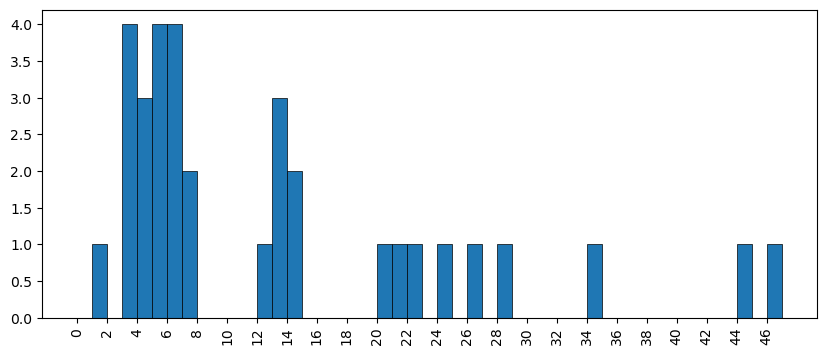

In [118]:
plot_gold_cluster_sizes(df = ArgKP21, bin_width = 1)

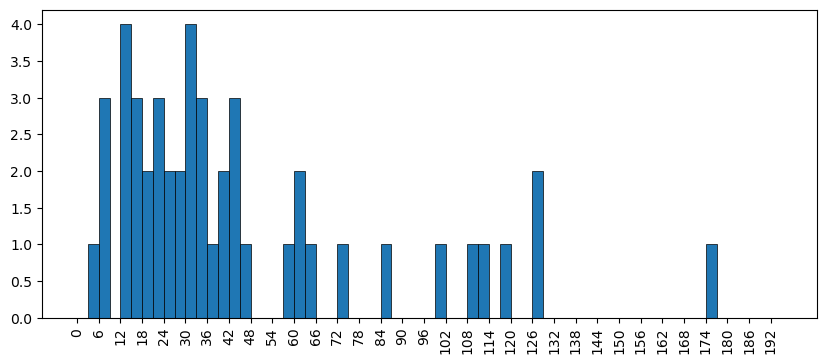

In [119]:
plot_gold_cluster_sizes(df = Debate, bin_width = 3)

## Clustering

### Summetix

In [61]:
summetix_parameter_dict = {'threshold':[np.round(i,4) for i in np.arange(0.05,0.96,0.025)],
                           'min_cluster_size':3}

In [ ]:
argkp_summetix_clusters = get_clusters(df = ArgKP21,
                                       get_clusters_callable = get_summetix_clusters,
                                       parameter_dict = summetix_parameter_dict,
                                       output_dir = 'investigations/1_argument_clusters',
                                       file_name = 'ArgKP21_Summetix.json')

In [ ]:
debate_summetix_clusters = get_clusters(df = Debate,
                                        get_clusters_callable = get_summetix_clusters,
                                        parameter_dict = summetix_parameter_dict,
                                        output_dir = 'investigations/1_argument_clusters',
                                        file_name = 'Debate_Summetix.json')

In [ ]:
debate_test_summetix_clusters = get_clusters(df = Debate_test,
                                             get_clusters_callable = get_summetix_clusters,
                                             parameter_dict = summetix_parameter_dict,
                                             output_dir = 'investigations/1_argument_clusters',
                                             file_name = 'Debate_test_Summetix.json')

### USKPM

In [4]:
uskpm_parameter_dict = {'n_neighbors':[i for i in range(2,6)],
                        'n_components':[i for i in range(2,6)],
                        'min_dist':[i for i in np.arange(0,0.41, 0.2)],
                        'min_cluster_size':3}

In [ ]:
argkp_uskpm_clusters = get_clusters(df = ArgKP21,
                                    get_clusters_callable = get_uskpm_clusters,
                                    parameter_dict = uskpm_parameter_dict,
                                    output_dir = 'investigations/1_argument_clusters',
                                    file_name = 'ArgKP21_USKPM.json',
                                    iterative_clustering = True)

In [ ]:
debate_uskpm_clusters = get_clusters(df = Debate,
                                     get_clusters_callable = get_uskpm_clusters,
                                     parameter_dict = uskpm_parameter_dict,
                                     output_dir = 'investigations/1_argument_clusters',
                                     file_name = 'Debate_USKPM.json',
                                     iterative_clustering = True)

In [5]:
debate_test_uskpm_clusters = get_clusters(df = Debate_test,
                                          get_clusters_callable = get_uskpm_clusters,
                                          parameter_dict = uskpm_parameter_dict,
                                          output_dir = 'investigations/1_argument_clusters',
                                          file_name = 'Debate_test_USKPM.json',
                                          iterative_clustering = True)

topic + stance:   0%|          | 0/8 [00:00<?, ?it/s]

parameter:   0%|          | 0/48 [00:00<?, ?it/s]

parameter:   0%|          | 0/48 [00:00<?, ?it/s]

parameter:   0%|          | 0/48 [00:00<?, ?it/s]

parameter:   0%|          | 0/48 [00:00<?, ?it/s]

parameter:   0%|          | 0/48 [00:00<?, ?it/s]

parameter:   0%|          | 0/48 [00:00<?, ?it/s]

parameter:   0%|          | 0/48 [00:00<?, ?it/s]

parameter:   0%|          | 0/48 [00:00<?, ?it/s]

### MCArgSum

#### RoBERTa

In [77]:
mcargsum_roberta_match_scorer= torch.load('models/match_scorer/cross_encoder/roberta_np/2024-Feb-20_08-20-28/best_model.pt')

mcargsum_roberta_parameter_dict = {'threshold':[np.round(i,4) for i in np.arange(0.05,0.96,0.025)],
                                    'min_cluster_size':3}

In [ ]:
argkp_mcargsum_roberta_clusters=  get_clusters(df = ArgKP21, 
                                               get_clusters_callable = get_match_clusters, 
                                               parameter_dict = mcargsum_roberta_parameter_dict, 
                                               match_scorer = mcargsum_roberta_match_scorer,
                                               output_dir = 'investigations/1_argument_clusters',
                                               file_name = 'ArgKP21_MCArgSum_RoBERTa.json')

In [ ]:
debate_mcargsum_roberta_clusters = get_clusters(df = Debate, 
                                                get_clusters_callable = get_match_clusters, 
                                                parameter_dict = mcargsum_roberta_parameter_dict, 
                                                match_scorer = mcargsum_roberta_match_scorer,
                                                output_dir = 'investigations/1_argument_clusters',
                                                file_name = 'Debate_MCArgSum_RoBERTa.json')

In [ ]:
debate_test_mcargsum_roberta_clusters = get_clusters(df = Debate_test, 
                                                     get_clusters_callable = get_match_clusters, 
                                                     parameter_dict = mcargsum_roberta_parameter_dict, 
                                                     match_scorer = mcargsum_roberta_match_scorer,
                                                     output_dir = 'investigations/1_argument_clusters',
                                                     file_name = 'Debate_test_MCArgSum_RoBERTa.json')

#### SBERT RoBERTa

In [79]:
mcargsum_sbert_roberta_match_scorer = SentenceTransformer('models/match_scorer/bi_encoder/roberta_tp/2024-Feb-20_16-23-49')

mcargsum_sbert_roberta_parameter_dict = {'threshold':[np.round(i,4) for i in np.arange(0.05,0.96,0.025)],
                                         'min_cluster_size':3}

In [ ]:
argkp_mcargsum_sbert_roberta__clusters = get_clusters(df = ArgKP21, 
                                                      get_clusters_callable = get_match_clusters, 
                                                      parameter_dict = mcargsum_sbert_roberta_parameter_dict,
                                                      match_scorer = mcargsum_sbert_roberta_match_scorer,
                                                      output_dir = 'investigations/1_argument_clusters',
                                                      file_name = 'ArgKP21_MCArgSum_SBERT_RoBERTa.json')

In [ ]:
debate_mcargsum_sbert_roberta__clusters = get_clusters(df = Debate, 
                                                       get_clusters_callable = get_match_clusters, 
                                                       parameter_dict = mcargsum_sbert_roberta_parameter_dict,
                                                       match_scorer = mcargsum_sbert_roberta_match_scorer,
                                                       output_dir = 'investigations/1_argument_clusters',
                                                       file_name = 'Debate_MCArgSum_SBERT_RoBERTa.json')

In [ ]:
debate_test_mcargsum_sbert_roberta__clusters = get_clusters(df = Debate_test, 
                                                            get_clusters_callable = get_match_clusters, 
                                                            parameter_dict = mcargsum_sbert_roberta_parameter_dict,
                                                            match_scorer = mcargsum_sbert_roberta_match_scorer,
                                                            output_dir = 'investigations/1_argument_clusters',
                                                            file_name = 'Debate_test_MCArgSum_SBERT_RoBERTa.json')

#### SBERT all-mpnet-base

In [47]:
mcargsum_sbert_all_mpnet_base_match_scorer = SentenceTransformer('models/match_scorer/bi_encoder/all-mpnet-base-v2/2024-Jun-05_22-29-27')

mcargsum_sbert_all_mpnet_base_parameter_dict = {'threshold':[np.round(i,4) for i in np.arange(0.05,0.96,0.025)],
                                                  'min_cluster_size':3}

In [ ]:
argkp_mcargsum_sbert_all_mpnet_base_clusters = get_clusters(df = ArgKP21, 
                                                            get_clusters_callable = get_match_clusters, 
                                                            parameter_dict = mcargsum_sbert_all_mpnet_base_parameter_dict,
                                                            match_scorer = mcargsum_sbert_all_mpnet_base_match_scorer,
                                                            output_dir = 'investigations/1_argument_clusters',
                                                            file_name = 'ArgKP21_MCArgSum_SBERT_all_mpnet_base.json')

In [ ]:
debate_test_mcargsum_sbert_all_mpnet_base_clusters = get_clusters(df = Debate_test,
                                                                  get_clusters_callable = get_match_clusters, 
                                                                  parameter_dict = mcargsum_sbert_all_mpnet_base_parameter_dict,
                                                                  match_scorer = mcargsum_sbert_all_mpnet_base_match_scorer,
                                                                  output_dir = 'investigations/1_argument_clusters',
                                                                  file_name = 'Debate_test_MCArgSum_SBERT_all_mpnet_base.json')

#### DeBERTa

In [81]:
mcargsum_deberta_match_scorer= torch.load('models/match_scorer/cross_encoder/deberta-v2_np/2024-Feb-20_13-41-02/best_model.pt')

mcargsum_deberta_parameter_dict = {'threshold':[np.round(i,4) for i in np.arange(0.05,0.96,0.025)],
                                    'min_cluster_size':3}

In [ ]:
argkp_mcargsum_deberta_clusters=  get_clusters(df = ArgKP21, 
                                               get_clusters_callable = get_match_clusters, 
                                               parameter_dict = mcargsum_deberta_parameter_dict, 
                                               match_scorer = mcargsum_deberta_match_scorer,
                                               output_dir = 'investigations/1_argument_clusters',
                                               file_name = 'ArgKP21_MCArgSum_DeBERTa.json')

In [ ]:
debate_mcargsum_deberta_clusters = get_clusters(df = Debate, 
                                                get_clusters_callable = get_match_clusters, 
                                                parameter_dict = mcargsum_deberta_parameter_dict, 
                                                match_scorer = mcargsum_deberta_match_scorer,
                                                output_dir = 'investigations/1_argument_clusters',
                                                file_name = 'Debate_MCArgSum_DeBERTa.json')

In [ ]:
debate_test_mcargsum_deberta_clusters = get_clusters(df = Debate_test, 
                                                     get_clusters_callable = get_match_clusters, 
                                                     parameter_dict = mcargsum_deberta_parameter_dict, 
                                                     match_scorer = mcargsum_deberta_match_scorer,
                                                     output_dir = 'investigations/1_argument_clusters',
                                                     file_name = 'Debate_test_MCArgSum_DeBERTa.json')

## Results

In [1]:
system_names = ['Summetix', 'USKPM', 'MCArgSum_RoBERTa', 'MCArgSum_SBERT_RoBERTa', 'MCArgSum_SBERT_mpnet_base', 'MCArgSum DeBERTa']
path = 'investigations/1_argument_clusters/'
ArgKP21_file_names = ['ArgKP21_Summetix.json', 'ArgKP21_USKPM.json','ArgKP21_MCArgSum_RoBERTa.json', 'ArgKP21_MCArgSum_SBERT_RoBERTa.json', 'ArgKP21_MCArgSum_SBERT_all_mpnet_base.json', 'ArgKP21_MCArgSum_DeBERTa.json']
Debate_test_file_names = ['Debate_test_Summetix.json', 'Debate_test_USKPM.json','Debate_test_MCArgSum_RoBERTa.json', 'Debate_test_MCArgSum_SBERT_RoBERTa.json', 'Debate_test_MCArgSum_SBERT_all_mpnet_base.json', 'Debate_test_MCArgSum_DeBERTa.json']

### ArgKP21

In [140]:
ari_systems, comp_systems, prop_clustered_systems, n_clusters_systems, runtime_systems, parameter_value_combinations_systems = get_results(df = ArgKP21, 
                                                                                                                                           system_names = system_names, 
                                                                                                                                           path = path, 
                                                                                                                                           file_names = ArgKP21_file_names)

topic + stance:   0%|          | 0/6 [00:00<?, ?it/s]

topic + stance:   0%|          | 0/6 [00:00<?, ?it/s]

topic + stance:   0%|          | 0/6 [00:00<?, ?it/s]

topic + stance:   0%|          | 0/6 [00:00<?, ?it/s]

topic + stance:   0%|          | 0/6 [00:00<?, ?it/s]

topic + stance:   0%|          | 0/6 [00:00<?, ?it/s]

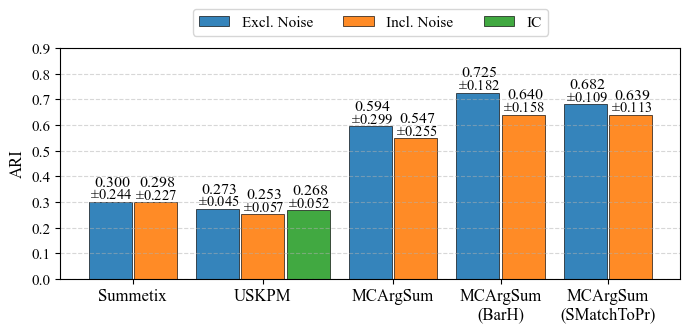

In [141]:
mean_aris_systems = []
std_aris_systems = []
for i in range(len(ari_systems)-1):
    mean_aris_scenarios = []
    std_aris_scenarios = []
    for s in [0,1,2]:   
        try:
            mean_aris_scenarios.append(np.mean(ari_systems[i][s]))
            std_aris_scenarios.append(np.std(ari_systems[i][s]))
        except:
            pass
    mean_aris_systems.append(mean_aris_scenarios)
    std_aris_systems.append(std_aris_scenarios)

plt.figure(figsize=(8,3))

plt.bar(0 + 0, mean_aris_systems[0][0], color = 'tab:blue', width = 0.4, label = 'Excl. Noise', edgecolor = 'black', linewidth = 0.5, alpha = 0.9)
plt.bar(0 + 0.42, mean_aris_systems[0][1], color = 'tab:orange', width = 0.4, label = 'Incl. Noise', edgecolor = 'black', linewidth = 0.5, alpha = 0.9)

plt.text(0 - 0.185 + 0.035, mean_aris_systems[0][0] + 0.062, f'{np.round(mean_aris_systems[0][0], 3)}00'[0:5], fontsize = 11.5)
plt.text(0 - 0.185, mean_aris_systems[0][0] + 0.012, r'$\pm$' + f'{np.round(std_aris_systems[0][0], 3)}00'[0:5], fontsize = 10.5)
plt.text(0 + 0.42 - 0.185 + 0.035, mean_aris_systems[0][1] + 0.062, f'{np.round(mean_aris_systems[0][1], 3)}00'[0:5], fontsize = 11.5)
plt.text(0 + 0.42 - 0.185, mean_aris_systems[0][1] + 0.012, r'$\pm$' + f'{np.round(std_aris_systems[0][1], 3)}00'[0:5], fontsize = 10.5)

plt.bar(1, mean_aris_systems[1][0], color = 'tab:blue', width = 0.4, edgecolor = 'black', linewidth = 0.5, alpha = 0.9)
plt.bar(1 + 0.42, mean_aris_systems[1][1], color = 'tab:orange', width = 0.4, edgecolor = 'black', linewidth = 0.5, alpha = 0.9)
plt.bar(1 + 0.84, mean_aris_systems[1][2], color = 'tab:green', width = 0.4, edgecolor = 'black', linewidth = 0.5, alpha = 0.9, label = 'IC')

plt.text(1 - 0.185 + 0.035, mean_aris_systems[1][0] + 0.062, f'{np.round(mean_aris_systems[1][0], 3)}00'[0:5], fontsize = 11.5)
plt.text(1 - 0.185, mean_aris_systems[1][0] + 0.012, r'$\pm$' + f'{np.round(std_aris_systems[1][0], 3)}00'[0:5], fontsize = 10.5)
plt.text(1 + 0.42 - 0.185 + 0.035, mean_aris_systems[1][1] + 0.062, f'{np.round(mean_aris_systems[1][1], 3)}00'[0:5], fontsize = 11.5)
plt.text(1 + 0.42 - 0.185, mean_aris_systems[1][1] + 0.012, r'$\pm$' + f'{np.round(std_aris_systems[1][1], 3)}00'[0:5], fontsize = 10.5)
plt.text(1 + 0.84 - 0.185 + 0.035, mean_aris_systems[1][2] + 0.062, f'{np.round(mean_aris_systems[1][2], 3)}00'[0:5], fontsize = 11.5)
plt.text(1 + 0.84 - 0.185, mean_aris_systems[1][2] + 0.012, r'$\pm$' + f'{np.round(std_aris_systems[1][2], 3)}00'[0:5], fontsize = 10.5)

plt.bar(2 + 0.42, mean_aris_systems[4][0], color = 'tab:blue', width = 0.4, edgecolor = 'black', linewidth = 0.5, alpha = 0.9)
plt.bar(2 + 0.84, mean_aris_systems[4][1], color = 'tab:orange', width = 0.4, edgecolor = 'black', linewidth = 0.5, alpha = 0.9)

plt.text(2 + 0.42 - 0.185 + 0.035, mean_aris_systems[4][0] + 0.062, f'{np.round(mean_aris_systems[4][0], 3)}00'[0:5], fontsize = 11.5)
plt.text(2 + 0.42 - 0.185, mean_aris_systems[4][0] + 0.012, r'$\pm$' + f'{np.round(std_aris_systems[4][0], 3)}00'[0:5], fontsize = 10.5)
plt.text(2 + 0.84 - 0.185 + 0.035, mean_aris_systems[4][1] + 0.062, f'{np.round(mean_aris_systems[4][1], 3)}00'[0:5], fontsize = 11.5)
plt.text(2 + 0.84 - 0.185, mean_aris_systems[4][1] + 0.012, r'$\pm$' + f'{np.round(std_aris_systems[4][1], 3)}00'[0:5], fontsize = 10.5)

plt.bar(3 + 0.42, mean_aris_systems[2][0], color = 'tab:blue', width = 0.4, edgecolor = 'black', linewidth = 0.5, alpha = 0.9)
plt.bar(3 + 0.84, mean_aris_systems[2][1], color = 'tab:orange', width = 0.4, edgecolor = 'black', linewidth = 0.5, alpha = 0.9)

plt.text(3 + 0.42 - 0.185 + 0.035, mean_aris_systems[2][0] + 0.062, f'{np.round(mean_aris_systems[2][0], 3)}00'[0:5], fontsize = 11.5)
plt.text(3 + 0.42 - 0.185, mean_aris_systems[2][0] + 0.012, r'$\pm$' + f'{np.round(std_aris_systems[2][0], 3)}00'[0:5], fontsize = 10.5)
plt.text(3 + 0.84 - 0.185 + 0.035, mean_aris_systems[2][1] + 0.062, f'{np.round(mean_aris_systems[2][1], 3)}00'[0:5], fontsize = 11.5)
plt.text(3 + 0.84 - 0.185, mean_aris_systems[2][1] + 0.012, r'$\pm$' + f'{np.round(std_aris_systems[2][1], 3)}00'[0:5], fontsize = 10.5)

plt.bar(4 + 0.42, mean_aris_systems[3][0], color = 'tab:blue', width = 0.4, edgecolor = 'black', linewidth = 0.5, alpha = 0.9)
plt.bar(4 + 0.84, mean_aris_systems[3][1], color = 'tab:orange', width = 0.4, edgecolor = 'black', linewidth = 0.5, alpha = 0.9)

plt.text(4 + 0.42 - 0.185 + 0.035, mean_aris_systems[3][0] + 0.062, f'{np.round(mean_aris_systems[3][0], 3)}00'[0:5], fontsize = 11.5)
plt.text(4 + 0.42 - 0.185, mean_aris_systems[3][0] + 0.012, r'$\pm$' + f'{np.round(std_aris_systems[3][0], 3)}00'[0:5], fontsize = 10.5)
plt.text(4 + 0.84 - 0.185 + 0.035, mean_aris_systems[3][1] + 0.062, f'{np.round(mean_aris_systems[3][1], 3)}00'[0:5], fontsize = 11.5)
plt.text(4 + 0.84 - 0.185, mean_aris_systems[3][1] + 0.012, r'$\pm$' + f'{np.round(std_aris_systems[3][1], 3)}00'[0:5], fontsize = 10.5)


plt.grid(axis = 'y', linestyle = '--', alpha = 0.5)
plt.xticks(ticks = [0.21, 1.42, 2.63, 3.63, 4.63], labels = ['Summetix', 'USKPM', 'MCArgSum', 'MCArgSum\n(BarH)', 'MCArgSum\n(SMatchToPr)'], fontsize = 12)
plt.yticks(fontsize = 11, ticks = [i for i in np.arange(0,0.91,0.1)])
plt.ylabel('ARI', fontsize = 12)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol = 3, fontsize = 11, fancybox = True)

plt.show()

In [46]:
system_idx = 0

print(system_names[system_idx])

index = ['ARI', 'Std', 'COMP', 'Std', 'Prop. Clustered', 'Std', 'Runtime', 'Std']
values = [np.round(np.mean(ari_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.std(ari_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.mean(comp_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.std(comp_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.mean(prop_clustered_systems[system_idx][0:2], axis = 1), 3),
          np.round(np.std(prop_clustered_systems[system_idx][0:2], axis = 1), 3),
          np.round(np.mean(runtime_systems[system_idx][0:2], axis = 1), 3),
          np.round(np.std(runtime_systems[system_idx][0:2], axis = 1), 3)]

pd.DataFrame(values, columns = ['clustering_no_noise', 'clustering_noise'], index = index).T

Summetix


,ARI,Std,COMP,Std,Prop. Clustered,Std,Runtime,Std
clustering_no_noise,0.300,0.244,0.469,0.178,0.859,0.089,0.675,0.044
clustering_noise,0.298,0.227,0.412,0.152,1.000,0.000,0.645,0.024


In [49]:
system_idx = 1

print(system_names[system_idx])

index = ['ARI', 'Std', 'COMP', 'Std', 'Prop. Clustered', 'Std', 'Runtime', 'Std']
values = [np.round(np.mean(ari_systems[system_idx][0:3], axis = 1), 3), 
          np.round(np.std(ari_systems[system_idx][0:3], axis = 1), 3), 
          np.round(np.mean(comp_systems[system_idx][0:3], axis = 1), 3), 
          np.round(np.std(comp_systems[system_idx][0:3], axis = 1), 3), 
          np.round(np.mean(prop_clustered_systems[system_idx][0:3], axis = 1), 3),
          np.round(np.std(prop_clustered_systems[system_idx][0:3], axis = 1), 3),
          np.round(np.mean(runtime_systems[system_idx][0:3], axis = 1), 3),
          np.round(np.std(runtime_systems[system_idx][0:3], axis = 1), 3)]

pd.DataFrame(values, columns = ['clustering_no_noise', 'clustering_noise', 'iterative_clustering'], index = index).T

USKPM


,ARI,Std,COMP,Std,Prop. Clustered,Std,Runtime,Std
clustering_no_noise,0.273,0.045,0.405,0.101,0.884,0.079,1.417,0.136
clustering_noise,0.253,0.057,0.375,0.100,1.000,0.000,1.478,0.113
iterative_clustering,0.268,0.052,0.397,0.108,1.000,0.000,4.377,4.378


In [50]:
system_idx = 2

print(system_names[system_idx])

index = ['ARI', 'Std', 'COMP', 'Std', 'Prop. Clustered', 'Std', 'Runtime', 'Std']
values = [np.round(np.mean(ari_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.std(ari_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.mean(comp_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.std(comp_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.mean(prop_clustered_systems[system_idx][0:2], axis = 1), 3),
          np.round(np.std(prop_clustered_systems[system_idx][0:2], axis = 1), 3),
          np.round(np.mean(runtime_systems[system_idx][0:2], axis = 1), 3),
          np.round(np.std(runtime_systems[system_idx][0:2], axis = 1), 3)]

pd.DataFrame(values, columns = ['clustering_no_noise', 'clustering_noise'], index = index).T

MCArgSum_RoBERTa


,ARI,Std,COMP,Std,Prop. Clustered,Std,Runtime,Std
clustering_no_noise,0.725,0.182,0.744,0.127,0.858,0.064,53.857,25.185
clustering_noise,0.640,0.158,0.675,0.136,1.000,0.000,53.857,25.185


In [51]:
system_idx = 3

print(system_names[system_idx])

index = ['ARI', 'Std', 'COMP', 'Std', 'Prop. Clustered', 'Std', 'Runtime', 'Std']
values = [np.round(np.mean(ari_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.std(ari_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.mean(comp_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.std(comp_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.mean(prop_clustered_systems[system_idx][0:2], axis = 1), 3),
          np.round(np.std(prop_clustered_systems[system_idx][0:2], axis = 1), 3),
          np.round(np.mean(runtime_systems[system_idx][0:2], axis = 1), 3),
          np.round(np.std(runtime_systems[system_idx][0:2], axis = 1), 3)]

pd.DataFrame(values, columns = ['clustering_no_noise', 'clustering_noise'], index = index).T

MCArgSum_SBERT_RoBERTa


,ARI,Std,COMP,Std,Prop. Clustered,Std,Runtime,Std
clustering_no_noise,0.682,0.109,0.777,0.118,0.881,0.042,2.723,0.435
clustering_noise,0.639,0.113,0.671,0.106,1.000,0.000,2.723,0.435


In [52]:
system_idx = 4

print(system_names[system_idx])

index = ['ARI', 'Std', 'COMP', 'Std', 'Prop. Clustered', 'Std', 'Runtime', 'Std']
values = [np.round(np.mean(ari_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.std(ari_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.mean(comp_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.std(comp_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.mean(prop_clustered_systems[system_idx][0:2], axis = 1), 3),
          np.round(np.std(prop_clustered_systems[system_idx][0:2], axis = 1), 3),
          np.round(np.mean(runtime_systems[system_idx][0:2], axis = 1), 3),
          np.round(np.std(runtime_systems[system_idx][0:2], axis = 1), 3)]

pd.DataFrame(values, columns = ['clustering_no_noise', 'clustering_noise'], index = index).T

MCArgSum_SBERT_mpnet_base


,ARI,Std,COMP,Std,Prop. Clustered,Std,Runtime,Std
clustering_no_noise,0.594,0.299,0.789,0.144,0.908,0.061,1.133,0.178
clustering_noise,0.547,0.255,0.566,0.214,1.000,0.000,1.133,0.178


In [53]:
system_idx = 5

print(system_names[system_idx])

index = ['ARI', 'Std', 'COMP', 'Std', 'Prop. Clustered', 'Std', 'Runtime', 'Std']
values = [np.round(np.mean(ari_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.std(ari_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.mean(comp_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.std(comp_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.mean(prop_clustered_systems[system_idx][0:2], axis = 1), 3),
          np.round(np.std(prop_clustered_systems[system_idx][0:2], axis = 1), 3),
          np.round(np.mean(runtime_systems[system_idx][0:2], axis = 1), 3),
          np.round(np.std(runtime_systems[system_idx][0:2], axis = 1), 3)]

pd.DataFrame(values, columns = ['clustering_no_noise', 'clustering_noise'], index = index).T

MCArgSum DeBERTa


,ARI,Std,COMP,Std,Prop. Clustered,Std,Runtime,Std
clustering_no_noise,0.699,0.182,0.734,0.141,0.894,0.066,46.8,15.88
clustering_noise,0.634,0.179,0.661,0.146,1.000,0.000,46.8,15.88


### Debate test

In [144]:
ari_systems, comp_systems, prop_clustered_systems, n_clusters_systems, runtime_systems, parameter_value_combinations_systems = get_results(df = Debate_test, 
                                                                                                                                           system_names = system_names,
                                                                                                                                           path = path, 
                                                                                                                                           file_names = Debate_test_file_names,
                                                                                                                                           t_prop_clustered = 0.70)

topic + stance:   0%|          | 0/8 [00:00<?, ?it/s]

topic + stance:   0%|          | 0/8 [00:00<?, ?it/s]

topic + stance:   0%|          | 0/8 [00:00<?, ?it/s]

topic + stance:   0%|          | 0/8 [00:00<?, ?it/s]

topic + stance:   0%|          | 0/8 [00:00<?, ?it/s]

topic + stance:   0%|          | 0/8 [00:00<?, ?it/s]

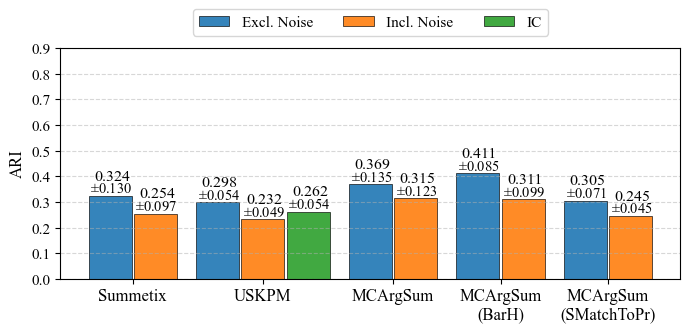

In [145]:
mean_aris_systems = []
std_aris_systems = []
for i in range(len(ari_systems)-1):
    mean_aris_scenarios = []
    std_aris_scenarios = []
    for s in [0,1,2]:   
        try:
            mean_aris_scenarios.append(np.mean(ari_systems[i][s]))
            std_aris_scenarios.append(np.std(ari_systems[i][s]))
        except:
            pass
    mean_aris_systems.append(mean_aris_scenarios)
    std_aris_systems.append(std_aris_scenarios)

plt.figure(figsize=(8,3))

plt.bar(0 + 0, mean_aris_systems[0][0], color = 'tab:blue', width = 0.4, label = 'Excl. Noise', edgecolor = 'black', linewidth = 0.5, alpha = 0.9)
plt.bar(0 + 0.42, mean_aris_systems[0][1], color = 'tab:orange', width = 0.4, label = 'Incl. Noise', edgecolor = 'black', linewidth = 0.5, alpha = 0.9)

plt.text(0 - 0.185 + 0.035, mean_aris_systems[0][0] + 0.062, f'{np.round(mean_aris_systems[0][0], 3)}00'[0:5], fontsize = 11.5)
plt.text(0 - 0.185, mean_aris_systems[0][0] + 0.012, r'$\pm$' + f'{np.round(std_aris_systems[0][0], 3)}00'[0:5], fontsize = 10.5)
plt.text(0 + 0.42 - 0.185 + 0.035, mean_aris_systems[0][1] + 0.062, f'{np.round(mean_aris_systems[0][1], 3)}00'[0:5], fontsize = 11.5)
plt.text(0 + 0.42 - 0.185, mean_aris_systems[0][1] + 0.012, r'$\pm$' + f'{np.round(std_aris_systems[0][1], 3)}00'[0:5], fontsize = 10.5)

plt.bar(1, mean_aris_systems[1][0], color = 'tab:blue', width = 0.4, edgecolor = 'black', linewidth = 0.5, alpha = 0.9)
plt.bar(1 + 0.42, mean_aris_systems[1][1], color = 'tab:orange', width = 0.4, edgecolor = 'black', linewidth = 0.5, alpha = 0.9)
plt.bar(1 + 0.84, mean_aris_systems[1][2], color = 'tab:green', width = 0.4, edgecolor = 'black', linewidth = 0.5, alpha = 0.9, label = 'IC')

plt.text(1 - 0.185 + 0.035, mean_aris_systems[1][0] + 0.062, f'{np.round(mean_aris_systems[1][0], 3)}00'[0:5], fontsize = 11.5)
plt.text(1 - 0.185, mean_aris_systems[1][0] + 0.012, r'$\pm$' + f'{np.round(std_aris_systems[1][0], 3)}00'[0:5], fontsize = 10.5)
plt.text(1 + 0.42 - 0.185 + 0.035, mean_aris_systems[1][1] + 0.062, f'{np.round(mean_aris_systems[1][1], 3)}00'[0:5], fontsize = 11.5)
plt.text(1 + 0.42 - 0.185, mean_aris_systems[1][1] + 0.012, r'$\pm$' + f'{np.round(std_aris_systems[1][1], 3)}00'[0:5], fontsize = 10.5)
plt.text(1 + 0.84 - 0.185 + 0.035, mean_aris_systems[1][2] + 0.062, f'{np.round(mean_aris_systems[1][2], 3)}00'[0:5], fontsize = 11.5)
plt.text(1 + 0.84 - 0.185, mean_aris_systems[1][2] + 0.012, r'$\pm$' + f'{np.round(std_aris_systems[1][2], 3)}00'[0:5], fontsize = 10.5)

plt.bar(2 + 0.42, mean_aris_systems[4][0], color = 'tab:blue', width = 0.4, edgecolor = 'black', linewidth = 0.5, alpha = 0.9)
plt.bar(2 + 0.84, mean_aris_systems[4][1], color = 'tab:orange', width = 0.4, edgecolor = 'black', linewidth = 0.5, alpha = 0.9)

plt.text(2 + 0.42 - 0.185 + 0.035, mean_aris_systems[4][0] + 0.062, f'{np.round(mean_aris_systems[4][0], 3)}00'[0:5], fontsize = 11.5)
plt.text(2 + 0.42 - 0.185, mean_aris_systems[4][0] + 0.012, r'$\pm$' + f'{np.round(std_aris_systems[4][0], 3)}00'[0:5], fontsize = 10.5)
plt.text(2 + 0.84 - 0.185 + 0.035, mean_aris_systems[4][1] + 0.062, f'{np.round(mean_aris_systems[4][1], 3)}00'[0:5], fontsize = 11.5)
plt.text(2 + 0.84 - 0.185, mean_aris_systems[4][1] + 0.012, r'$\pm$' + f'{np.round(std_aris_systems[4][1], 3)}00'[0:5], fontsize = 10.5)

plt.bar(3 + 0.42, mean_aris_systems[2][0], color = 'tab:blue', width = 0.4, edgecolor = 'black', linewidth = 0.5, alpha = 0.9)
plt.bar(3 + 0.84, mean_aris_systems[2][1], color = 'tab:orange', width = 0.4, edgecolor = 'black', linewidth = 0.5, alpha = 0.9)

plt.text(3 + 0.42 - 0.185 + 0.035, mean_aris_systems[2][0] + 0.062, f'{np.round(mean_aris_systems[2][0], 3)}00'[0:5], fontsize = 11.5)
plt.text(3 + 0.42 - 0.185, mean_aris_systems[2][0] + 0.012, r'$\pm$' + f'{np.round(std_aris_systems[2][0], 3)}00'[0:5], fontsize = 10.5)
plt.text(3 + 0.84 - 0.185 + 0.035, mean_aris_systems[2][1] + 0.062, f'{np.round(mean_aris_systems[2][1], 3)}00'[0:5], fontsize = 11.5)
plt.text(3 + 0.84 - 0.185, mean_aris_systems[2][1] + 0.012, r'$\pm$' + f'{np.round(std_aris_systems[2][1], 3)}00'[0:5], fontsize = 10.5)

plt.bar(4 + 0.42, mean_aris_systems[3][0], color = 'tab:blue', width = 0.4, edgecolor = 'black', linewidth = 0.5, alpha = 0.9)
plt.bar(4 + 0.84, mean_aris_systems[3][1], color = 'tab:orange', width = 0.4, edgecolor = 'black', linewidth = 0.5, alpha = 0.9)

plt.text(4 + 0.42 - 0.185 + 0.035, mean_aris_systems[3][0] + 0.062, f'{np.round(mean_aris_systems[3][0], 3)}00'[0:5], fontsize = 11.5)
plt.text(4 + 0.42 - 0.185, mean_aris_systems[3][0] + 0.012, r'$\pm$' + f'{np.round(std_aris_systems[3][0], 3)}00'[0:5], fontsize = 10.5)
plt.text(4 + 0.84 - 0.185 + 0.035, mean_aris_systems[3][1] + 0.062, f'{np.round(mean_aris_systems[3][1], 3)}00'[0:5], fontsize = 11.5)
plt.text(4 + 0.84 - 0.185, mean_aris_systems[3][1] + 0.012, r'$\pm$' + f'{np.round(std_aris_systems[3][1], 3)}00'[0:5], fontsize = 10.5)


plt.grid(axis = 'y', linestyle = '--', alpha = 0.5)
plt.xticks(ticks = [0.21, 1.42, 2.63, 3.63, 4.63], labels = ['Summetix', 'USKPM', 'MCArgSum', 'MCArgSum\n(BarH)', 'MCArgSum\n(SMatchToPr)'], fontsize = 12)
plt.yticks(fontsize = 11, ticks = [i for i in np.arange(0,0.91,0.1)])
plt.ylabel('ARI', fontsize = 12)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol = 3, fontsize = 11, fancybox = True)

plt.show()

In [7]:
system_idx = 0

print(system_names[system_idx])

index = ['ARI', 'Std', 'COMP', 'Std', 'Prop. Clustered', 'Std', 'Runtime', 'Std']
values = [np.round(np.mean(ari_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.std(ari_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.mean(comp_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.std(comp_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.mean(prop_clustered_systems[system_idx][0:2], axis = 1), 3),
          np.round(np.std(prop_clustered_systems[system_idx][0:2], axis = 1), 3),
          np.round(np.mean(runtime_systems[system_idx][0:2], axis = 1), 3),
          np.round(np.std(runtime_systems[system_idx][0:2], axis = 1), 3)]

pd.DataFrame(values, columns = ['clustering_no_noise', 'clustering_noise'], index = index).T

Summetix


,ARI,Std,COMP,Std,Prop. Clustered,Std,Runtime,Std
clustering_no_noise,0.324,0.130,0.477,0.139,0.823,0.071,0.738,0.075
clustering_noise,0.254,0.097,0.382,0.090,1.000,0.000,0.722,0.068


In [13]:
system_idx = 1

print(system_names[system_idx])

index = ['ARI', 'Std', 'COMP', 'Std', 'Prop. Clustered', 'Std', 'Runtime', 'Std']
values = [np.round(np.mean(ari_systems[system_idx][0:3], axis = 1), 3), 
          np.round(np.std(ari_systems[system_idx][0:3], axis = 1), 3), 
          np.round(np.mean(comp_systems[system_idx][0:3], axis = 1), 3), 
          np.round(np.std(comp_systems[system_idx][0:3], axis = 1), 3), 
          np.round(np.mean(prop_clustered_systems[system_idx][0:3], axis = 1), 3),
          np.round(np.std(prop_clustered_systems[system_idx][0:3], axis = 1), 3),
          np.round(np.mean(runtime_systems[system_idx][0:3], axis = 1), 3),
          np.round(np.std(runtime_systems[system_idx][0:3], axis = 1), 3)]

pd.DataFrame(values, columns = ['clustering_no_noise', 'clustering_noise', 'iterative clustering'], index = index).T

USKPM


,ARI,Std,COMP,Std,Prop. Clustered,Std,Runtime,Std
clustering_no_noise,0.298,0.054,0.430,0.046,0.797,0.051,2.090,0.518
clustering_noise,0.232,0.049,0.365,0.048,1.000,0.000,2.044,0.507
iterative clustering,0.262,0.054,0.380,0.048,1.000,0.000,15.384,9.633


In [9]:
system_idx = 2

print(system_names[system_idx])

index = ['ARI', 'Std', 'COMP', 'Std', 'Prop. Clustered', 'Std', 'Runtime', 'Std']
values = [np.round(np.mean(ari_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.std(ari_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.mean(comp_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.std(comp_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.mean(prop_clustered_systems[system_idx][0:2], axis = 1), 3),
          np.round(np.std(prop_clustered_systems[system_idx][0:2], axis = 1), 3),
          np.round(np.mean(runtime_systems[system_idx][0:2], axis = 1), 3),
          np.round(np.std(runtime_systems[system_idx][0:2], axis = 1), 3)]

pd.DataFrame(values, columns = ['clustering_no_noise', 'clustering_noise'], index = index).T

MCArgSum_RoBERTa


,ARI,Std,COMP,Std,Prop. Clustered,Std,Runtime,Std
clustering_no_noise,0.411,0.085,0.489,0.091,0.789,0.079,201.866,166.687
clustering_noise,0.311,0.099,0.438,0.125,1.000,0.000,201.866,166.686


In [20]:
system_idx = 3

print(system_names[system_idx])

index = ['ARI', 'Std', 'COMP', 'Std', 'Prop. Clustered', 'Std', 'Runtime', 'Std']
values = [np.round(np.mean(ari_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.std(ari_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.mean(comp_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.std(comp_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.mean(prop_clustered_systems[system_idx][0:2], axis = 1), 3),
          np.round(np.std(prop_clustered_systems[system_idx][0:2], axis = 1), 3),
          np.round(np.mean(runtime_systems[system_idx][0:2], axis = 1), 3),
          np.round(np.std(runtime_systems[system_idx][0:2], axis = 1), 3)]

pd.DataFrame(values, columns = ['clustering_no_noise', 'clustering_noise'], index = index).T

MCArgSum_SBERT_RoBERTa


,ARI,Std,COMP,Std,Prop. Clustered,Std,Runtime,Std
clustering_no_noise,0.305,0.071,0.414,0.079,0.783,0.068,6.109,2.323
clustering_noise,0.245,0.045,0.364,0.066,1.000,0.000,6.109,2.323


In [21]:
system_idx = 4

print(system_names[system_idx])

index = ['ARI', 'Std', 'COMP', 'Std', 'Prop. Clustered', 'Std', 'Runtime', 'Std']
values = [np.round(np.mean(ari_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.std(ari_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.mean(comp_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.std(comp_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.mean(prop_clustered_systems[system_idx][0:2], axis = 1), 3),
          np.round(np.std(prop_clustered_systems[system_idx][0:2], axis = 1), 3),
          np.round(np.mean(runtime_systems[system_idx][0:2], axis = 1), 3),
          np.round(np.std(runtime_systems[system_idx][0:2], axis = 1), 3)]

pd.DataFrame(values, columns = ['clustering_no_noise', 'clustering_noise'], index = index).T

MCArgSum_SBERT_mpnet_base


,ARI,Std,COMP,Std,Prop. Clustered,Std,Runtime,Std
clustering_no_noise,0.369,0.135,0.447,0.078,0.878,0.095,1.931,0.69
clustering_noise,0.315,0.123,0.399,0.104,1.000,0.000,1.931,0.69


In [22]:
system_idx = 5

print(system_names[system_idx])

index = ['ARI', 'Std', 'COMP', 'Std', 'Prop. Clustered', 'Std', 'Runtime', 'Std']
values = [np.round(np.mean(ari_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.std(ari_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.mean(comp_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.std(comp_systems[system_idx][0:2], axis = 1), 3), 
          np.round(np.mean(prop_clustered_systems[system_idx][0:2], axis = 1), 3),
          np.round(np.std(prop_clustered_systems[system_idx][0:2], axis = 1), 3),
          np.round(np.mean(runtime_systems[system_idx][0:2], axis = 1), 3),
          np.round(np.std(runtime_systems[system_idx][0:2], axis = 1), 3)]

pd.DataFrame(values, columns = ['clustering_no_noise', 'clustering_noise'], index = index).T

MCArgSum DeBERTa


,ARI,Std,COMP,Std,Prop. Clustered,Std,Runtime,Std
clustering_no_noise,0.398,0.181,0.488,0.108,0.833,0.093,298.645,242.07
clustering_noise,0.337,0.156,0.419,0.100,1.000,0.000,298.645,242.07
